In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import head
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import pdb
import warnings
warnings.filterwarnings("ignore")

In [4]:
"""Generate a target spectrum
We simulate a target spectrum and pass it as a head.UVVis object to the BO algorithm

You would eventually do the following:
wav : array of wavelengths
abs_ : array of absorptions same shape as wav
st = head.UVVis(wav, abs_)
"""
from head import get_spectrum
Lt, Rt = 2, 1
st = get_spectrum(Lt,Rt)


In [5]:
"""
create a search space
We assign each point on the 2-dimensional hyperplane a spectrum by randomly sampling
the equivalent Euclidean grid of 2-dimensions of sqrt(L), L/D.
the result is a table with each column as a spectra indexed by rows of concentration array in hplane.space
"""

NUM = 10
c1 = np.linspace(0,1,num=NUM)
c2 = np.linspace(0,1,num=NUM)
c3 = np.linspace(0,1,num=NUM)

hplane = head.Hyperplane(c1,c2,c3)

X = np.linspace(1,2, num=NUM) # sqrt(L)
Y = np.linspace(1,2, num=NUM) # l/D
grid = head.Euclidean(X,Y)

grid_samples = grid.sample(n_samples=len(hplane))

spectra = {}
for i,pi in enumerate(grid_samples):
    L = pi[0]**2
    R = 0.5*(L/pi[1])
    s = head.get_spectrum(L,R)
    spectra[i]= s.fd.data_matrix.squeeze()
spectra['wav'] = s.fd.grid_points[0]
df = pd.DataFrame.from_dict(spectra)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,wav
0,0.811053,0.221580,0.221580,0.503651,0.811053,0.152557,0.475140,0.532772,0.811053,0.178392,...,0.573897,0.221580,0.811053,0.475140,0.573897,0.811053,0.152557,0.811053,0.811053,400.000000
1,0.790198,0.217185,0.217185,0.490851,0.790198,0.149382,0.463765,0.521481,0.790198,0.176255,...,0.564388,0.217185,0.790198,0.463765,0.564388,0.790198,0.149382,0.790198,0.790198,412.244898
2,0.773873,0.211285,0.211285,0.477658,0.773873,0.145069,0.451711,0.508245,0.773873,0.172762,...,0.552160,0.211285,0.773873,0.451711,0.552160,0.773873,0.145069,0.773873,0.773873,424.489796
3,0.771616,0.205571,0.205571,0.471121,0.771616,0.140478,0.445786,0.498485,0.771616,0.168011,...,0.543230,0.205571,0.771616,0.445786,0.543230,0.771616,0.140478,0.771616,0.771616,436.734694
4,0.782198,0.200025,0.200025,0.470441,0.782198,0.135634,0.445258,0.492182,0.782198,0.162261,...,0.537769,0.200025,0.782198,0.445258,0.537769,0.782198,0.135634,0.782198,0.782198,448.979592


In [6]:
# define a model for the loss function we would like to optimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

kernel = 1.0 * Matern(length_scale=0.2, nu=1.5)
model = GaussianProcessRegressor(kernel=kernel)

In [7]:
query_strategy = head.thomspon_sampling

In [8]:
# a sample function to retreive a spectrum given a composition array
# this is a simple lookup table 
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
neigh.fit(hplane.space)

def _get_closest_spectrum(df, x):
    """
    Given a concentration array, return a spectrum as a head.UVVis object
    """
    x = np.asarray(x).reshape(1,3)
    _, ind = neigh.kneighbors(x, n_neighbors=1)
    s = df.iloc[:,int(ind)].to_numpy()
    return head.UVVis(df['wav'].to_numpy(), s)

def get_batch_spectrums(df,Xb):
    """
    This functions takes a set of concentrations as an array of shape (n_samples x dimension)
    and returns a list of spectra each indexed by rows of the concentration array Xb
    
    Here for example, we lookup the concentration in the table df and return the corresponding spectra.
    
    Note that you need to convert each spectra into a head.UVVis object,
    see the function `_get_closest_spectrum` for an example usage
    
    """
    Sb = []
    for xi in Xb:
        si = _get_closest_spectrum(df, xi)
        Sb.append(si)
        
    return Sb

def get_OT2_batch(df, Xb):
    """
    I have written down a skeleton function for processing the OT2 batch samples towards this optimization
    This function simply mimics the above `get_batch_spectrums` but instead takes in a dataframe 
    df roughly looking like the following:
        -- it has one column named `wav` that is an array of wavelengths
        -- multiple other columns (equals to the batch size Xb)
        
    The function must return a list Sb indexed by the rows of Xb. 
    The entries of Sb are formated to the inbuilt head.UVVis object
    """
    Sb = []
    names = df.columns.to_list()
    names.remove('wav')
    for i in range(len(Xb)):
        sbi = head.UVVis(df['wav'].to_numpy(), df[names[i]].to_numpy())
        Sb.append(sbi)
    
    return Sb

In [9]:
from head.metrics import func_norm, euclidean_dist

def oracle(si,st):
    """Scoring function between two spectra
    Given two spectra in si, st compute a score between them.
    Note that here si, st are represented using the class `head.UVVis`.
    If you are using arrays, you'd have to make necessary transformations.
    """
    return euclidean_dist(si,st)

In [10]:
experiment = {}

In [11]:
from modAL.models import BayesianOptimizer

design = head.ExampleRunner(hplane)
design.add_target(st,Lt=Lt,Rt=Rt)
design.set_params(**{'oracle':oracle,
                     'st':st
                    }
                 )

n_iterations = 2 # total number of iterations to run the batch search for
batch_size = 5 # batch size requested in each query
n_initial = 2 # number of intitial samples to select randomly

# initiate the optimization by randomly sampling `n_initial` samples
X0 = design.request_batch(n_initial, is_init=True)
print('Requested batch evaluation for the following: ', X0,'\n')

# You would eventually replace this function using the `get_OT2batch` at appropriate places
S0 = get_batch_spectrums(df,X0)
print('Obtained %d spectra as a list'%len(S0),'\n')
Y0 = design.evaluate_batch(S0)
print('Obtained score values for the current batch are: ',Y0,'\n')

experiment.update({0:(X0,S0,Y0)})

# create a optimizer module with the obtained initial samples from above
optimizer = BayesianOptimizer(
    estimator=model,
    query_strategy=query_strategy,
    X_training = X0,
    y_training = Y0
)

design.set_params(**{'optimizer':optimizer})

for n_iter in range(n_iterations):
    Xb = design.request_batch(batch_size, is_init=False)
    print('Requested batch evaluation for the following:\n', Xb,'\n')
    Sb = get_batch_spectrums(df,Xb)
    print('Obtained %d spectra as a list'%len(Sb),'\n')
    Yb = design.evaluate_batch(Sb)
    print('Obtained score values for the %d batch are: '%n_iter,Yb,'\n')
    experiment.update({n_iter+1:(Xb,Sb,Yb)})
    design.optimizer.teach(Xb, Yb)

Requested batch evaluation for the following:  [[0.66666667 0.11111111 0.22222222]
 [0.55555556 0.33333333 0.11111111]] 

Obtained 2 spectra as a list 

1
Obtained score values for the current batch are:  [-1.61998197 -0.74152664] 

Requested batch evaluation for the following:
 [[0.22222222 0.77777778 0.        ]
 [0.         0.44444444 0.55555556]
 [0.44444444 0.55555556 0.        ]
 [0.33333333 0.33333333 0.33333333]
 [0.         0.11111111 0.88888889]] 

Obtained 5 spectra as a list 

2
Obtained score values for the 0 batch are:  [-1.61998197 -2.07103414 -2.21188075 -1.61998197 -1.61998197] 

Requested batch evaluation for the following:
 [[0.33333333 0.         0.66666667]
 [0.         1.         0.        ]
 [0.22222222 0.         0.77777778]
 [0.11111111 0.22222222 0.66666667]
 [0.55555556 0.22222222 0.22222222]] 

Obtained 5 spectra as a list 

3
Obtained score values for the 1 batch are:  [-0.73540592 -1.61998197 -1.66765319 -1.61998197 -0.41323826] 



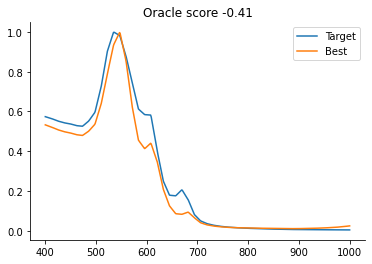

In [12]:
design.plot_bestmatch()

In [14]:
import pickle

with open('../data/expt.pkl', 'wb') as handle:
    pickle.dump(experiment, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../data/expt.pkl', 'rb') as handle:
    b = pickle.load(handle)